In [3]:
#install dependencies
!pip install ultralytics --upgrade
!pip install opencv-python matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00a 0:00:01


In [4]:
# Download the Car Parts dataset directly from GitHub

!git clone https://github.com/dsmlr/Car-Parts-Segmentation.git


fatal: destination path 'Car-Parts-Segmentation' already exists and is not an empty directory.


In [5]:
#import libraries

import os
import json
import shutil
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import random



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Define source and destination directories
base_input = '/kaggle/input/car-parts-detection-dataset'
base_work  = '/kaggle/working/carparts_yolo_ready'

train_input = os.path.join(base_input, 'trainingset', 'JPEGImages')
test_input  = os.path.join(base_input, 'testset', 'JPEGImages')

train_work = os.path.join(base_work, 'trainingset')
test_work  = os.path.join(base_work, 'testset')

# Create YOLO-style directory structure
for split in ['trainingset', 'testset']:
    os.makedirs(os.path.join(base_work, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_work, split, 'labels'), exist_ok=True)

# Copy images
shutil.copytree(train_input, os.path.join(train_work, 'images'), dirs_exist_ok=True)
shutil.copytree(test_input,  os.path.join(test_work, 'images'),  dirs_exist_ok=True)
print("✅ Images copied to working directory")

# Function to convert COCO JSON annotations → YOLO .txt labels
def convert_annotations(json_file, img_dir, label_dir):
    with open(json_file) as f:
        data = json.load(f)
    images = {img['id']: img for img in data['images']}
    
    for ann in tqdm(data['annotations'], desc=f"Converting {os.path.basename(json_file)}"):
        if 'bbox' not in ann: 
            continue
        img_info = images[ann['image_id']]
        x, y, w, h = ann['bbox']
        img_path = os.path.join(img_dir, img_info['file_name'])
        img_cv = cv2.imread(img_path)
        if img_cv is None:  # skip unreadable
            continue
        ih, iw = img_cv.shape[:2]
        # Normalize
        x_center = (x + w/2) / iw
        y_center = (y + h/2) / ih
        w /= iw
        h /= ih
        cls = int(ann['category_id'])
        # Write YOLO-format label
        label_path = os.path.join(label_dir, os.path.splitext(img_info['file_name'])[0] + '.txt')
        with open(label_path, 'a') as f:
            f.write(f"{cls} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

# Convert both train and test annotations
convert_annotations(os.path.join(base_input, 'trainingset', 'annotations.json'),
                    os.path.join(train_work, 'images'),
                    os.path.join(train_work, 'labels'))

convert_annotations(os.path.join(base_input, 'testset', 'annotations.json'),
                    os.path.join(test_work, 'images'),
                    os.path.join(test_work, 'labels'))

print("✅ Labels generated successfully")


✅ Images copied to working directory


Converting annotations.json: 100%|██████████| 811/811 [00:01<00:00, 576.97it/s]

✅ Labels generated successfully


In [15]:
yaml_path = '/kaggle/working/carparts_yolo_ready/carparts.yaml'

yaml_content = """
train: /kaggle/working/carparts_yolo_ready/trainingset/images
val: /kaggle/working/carparts_yolo_ready/testset/images

nc: 20
names: [
  'front_bumper', 'rear_bumper', 'door', 'hood', 'wheel', 'window',
  'mirror', 'headlight', 'taillight', 'grille', 'trunk', 'roof',
  'fender', 'side_skirt', 'windshield', 'license_plate',
  'spoiler', 'logo', 'handle', 'fuel_cap'
]
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("✅ YAML updated successfully!")
print(open(yaml_path).read())


✅ YAML updated successfully!

train: /kaggle/working/carparts_yolo_ready/trainingset/images
val: /kaggle/working/carparts_yolo_ready/testset/images

nc: 20
names: [
  'front_bumper', 'rear_bumper', 'door', 'hood', 'wheel', 'window',
  'mirror', 'headlight', 'taillight', 'grille', 'trunk', 'roof',
  'fender', 'side_skirt', 'windshield', 'license_plate',
  'spoiler', 'logo', 'handle', 'fuel_cap'
]



In [16]:
#clear cache
!rm -f /kaggle/working/carparts_yolo_ready/trainingset/labels.cache
!rm -f /kaggle/working/carparts_yolo_ready/testset/labels.cache
print("Cache cleared ✅")


Cache cleared ✅


In [17]:
train_img_dir = '/kaggle/working/carparts_yolo_ready/trainingset/images'
train_lbl_dir = '/kaggle/working/carparts_yolo_ready/trainingset/labels'
test_img_dir  = '/kaggle/working/carparts_yolo_ready/testset/images'
test_lbl_dir  = '/kaggle/working/carparts_yolo_ready/testset/labels'

print("Training images:", len(os.listdir(train_img_dir)))
print("Training labels:", len(os.listdir(train_lbl_dir)))
print("Testing images:", len(os.listdir(test_img_dir)))
print("Testing labels:", len(os.listdir(test_lbl_dir)))


Training images: 400
Training labels: 400
Testing images: 100
Testing labels: 100


In [9]:
#verify label file contents
import os

train_lbl_dir = '/kaggle/working/carparts_yolo_ready/trainingset/labels'
bad = []
for f in os.listdir(train_lbl_dir):
    if f.endswith('.txt'):
        with open(os.path.join(train_lbl_dir, f)) as fh:
            for line in fh:
                parts = line.strip().split()
                # must be 5 numbers, all convertible to float
                if len(parts) != 5:
                    bad.append(f)
                    break
                try:
                    _ = [float(x) for x in parts[1:]]
                except:
                    bad.append(f)
                    break
print("Files with bad label lines:", len(bad))
for b in bad[:10]:
    print(" ->", b)


Files with bad label lines: 0


In [10]:
#autorepair misinformed labels
import json, cv2, os
from tqdm import tqdm

base_in = '/kaggle/input/car-parts-detection-dataset'
base_out = '/kaggle/working/carparts_yolo_ready'

def safe_convert(split):
    src_json = f'{base_in}/{split}/annotations.json'
    img_dir  = f'{base_out}/{split}/images'
    lbl_dir  = f'{base_out}/{split}/labels'
    os.makedirs(lbl_dir, exist_ok=True)

    with open(src_json) as f:
        coco = json.load(f)
    imgs = {im['id']: im for im in coco['images']}
    print(f"Re-creating labels for {split} …")

    n_ok = 0
    for ann in tqdm(coco['annotations']):
        if 'bbox' not in ann or len(ann['bbox']) != 4: 
            continue
        img_info = imgs.get(ann['image_id'])
        if not img_info: 
            continue
        path = os.path.join(img_dir, img_info['file_name'])
        im = cv2.imread(path)
        if im is None: 
            continue
        h, w = im.shape[:2]
        x, y, bw, bh = ann['bbox']
        if bw<=0 or bh<=0: 
            continue
        x_c=(x+bw/2)/w; y_c=(y+bh/2)/h; bw/=w; bh/=h
        vals=[x_c,y_c,bw,bh]
        if not all(0<=v<=1 for v in vals): 
            continue
        cls=int(ann['category_id'])-1   # zero-index
        with open(os.path.join(lbl_dir, os.path.splitext(img_info['file_name'])[0]+'.txt'),'a') as f:
            f.write(f"{cls} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n")
        n_ok+=1
    print(f"✅ {n_ok} valid boxes written for {split}")

safe_convert('trainingset')
safe_convert('testset')


Re-creating labels for trainingset …


100%|██████████| 3073/3073 [00:04<00:00, 696.24it/s]


✅ 3073 valid boxes written for trainingset
Re-creating labels for testset …


100%|██████████| 811/811 [00:01<00:00, 567.57it/s]

✅ 811 valid boxes written for testset


In [11]:
#clear yolo cache and re-check counts
!rm -f /kaggle/working/carparts_yolo_ready/trainingset/labels.cache
!rm -f /kaggle/working/carparts_yolo_ready/testset/labels.cache
print("Caches cleared ✅")

print("Label files in train:", len(os.listdir('/kaggle/working/carparts_yolo_ready/trainingset/labels')))


Caches cleared ✅
Label files in train: 400


In [18]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')

results = model.train(
    data='/kaggle/working/carparts_yolo_ready/carparts.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    project='/kaggle/working',
    name='car_parts_detection_fixed_classes',
    amp=False,
    deterministic=False
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/carparts_yolo_ready/carparts.yaml, degrees=0.0, deterministic=False, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_parts_detection_fixed_classes, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

In [19]:
from ultralytics import YOLO

# Load the best model from training
model = YOLO('/kaggle/working/car_parts_detection_fixed_classes/weights/best.pt')

# Evaluate on the validation (test) set
metrics = model.val(
    data='/kaggle/working/carparts_yolo_ready/carparts.yaml',
    imgsz=640,
    batch=8,
    verbose=True
)

print(f"✅ mAP@[IoU=50]: {metrics.box.map50:.4f}")
print(f"✅ mAP@[IoU=50:95]: {metrics.box.map:.4f}")


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 978.9±410.5 MB/s, size: 35.2 KB)
val: Scanning /kaggle/working/carparts_yolo_ready/testset/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 235.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 5.9it/s 2.2s0.1s
                   all        100       1622      0.613      0.783      0.682       0.51
           rear_bumper         18         18      0.736      0.932      0.901      0.735
                  door         20         38       0.63      0.816      0.819      0.621
                  hood         45         51      0.481      0.922      0.717      0.534
                 wheel         42         51      0.469      0.744      0.484      0.368
                windo


image 1/1 /kaggle/working/carparts_yolo_ready/testset/images/car77.jpg: 640x640 1 rear_bumper, 2 doors, 2 hoods, 3 wheels, 2 windows, 2 mirrors, 2 headlights, 1 windshield, 1 license_plate, 1 spoiler, 2 logos, 3 handles, 3 fuel_caps, 10.3ms
Speed: 3.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/predict


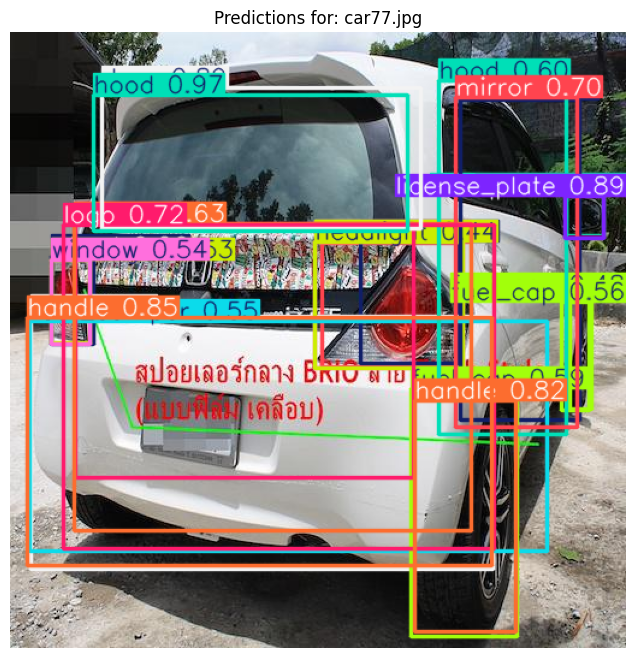


image 1/1 /kaggle/working/carparts_yolo_ready/testset/images/te80.jpg: 480x640 1 hood, 1 wheel, 1 headlight, 2 taillights, 2 grilles, 1 trunk, 2 roofs, 1 fender, 2 side_skirts, 2 windshields, 1 license_plate, 1 spoiler, 1 handle, 1 fuel_cap, 53.0ms
Speed: 2.0ms preprocess, 53.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /kaggle/working/runs/detect/predict


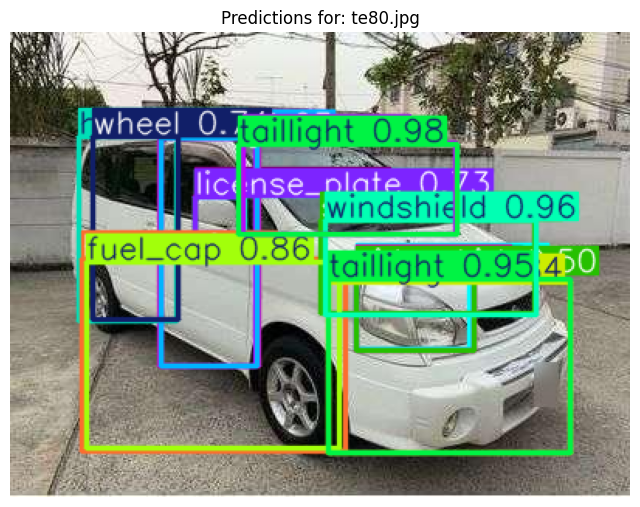

In [21]:
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os

# Folder with test images
test_img_dir = '/kaggle/working/carparts_yolo_ready/testset/images'

# Pick 2 random test images
sample_images = random.sample(os.listdir(test_img_dir), 2)

for img_name in sample_images:
    img_path = os.path.join(test_img_dir, img_name)
    results = model.predict(source=img_path, conf=0.25, imgsz=640, save=True)
    
    # Get the first result
    r = results[0]
    
    # Plot predictions directly on the image
    annotated_img = r.plot()  # returns a BGR numpy image with boxes drawn
    
    # Convert BGR → RGB for matplotlib
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.title(f"Predictions for: {img_name}")
    plt.show()


In [23]:
import numpy as np

# Class-wise mAP values
class_maps = metrics.box.maps
class_names = [
  'front_bumper', 'rear_bumper', 'door', 'hood', 'wheel', 'window',
  'mirror', 'headlight', 'taillight', 'grille', 'trunk', 'roof',
  'fender', 'side_skirt', 'windshield', 'license_plate',
  'spoiler', 'logo', 'handle', 'fuel_cap'
]

print("📊 Class-wise Average Precision (AP):")
for i, ap in enumerate(class_maps):
    print(f"{class_names[i]:<15}: {ap:.4f}")

# Find the class with the lowest AP
worst_idx = int(np.argmin(class_maps))
print(f"\n🚨 Hardest to detect class: {class_names[worst_idx]} (AP: {class_maps[worst_idx]:.4f})")


📊 Class-wise Average Precision (AP):
front_bumper   : 0.5102
rear_bumper    : 0.7354
door           : 0.6208
hood           : 0.5341
wheel          : 0.3685
window         : 0.3432
mirror         : 0.3516
headlight      : 0.7868
taillight      : 0.7937
grille         : 0.7493
trunk          : 0.2996
roof           : 0.3232
fender         : 0.3950
side_skirt     : 0.5541
windshield     : 0.5757
license_plate  : 0.4999
spoiler        : 0.3177
logo           : 0.6152
handle         : 0.3999
fuel_cap       : 0.4302

🚨 Hardest to detect class: trunk (AP: 0.2996)


**Difficult Class to Localize**

From the class-wise results, I noticed that the trunk was the hardest part for the model to detect and localize accurately. In most test images, the trunk either appeared partially or blended with the rear bumper and taillights, which probably confused the model. Since both the color and texture of these parts are quite similar, the model struggled to identify clear boundaries for the trunk. I think another reason could be that the dataset doesn’t have enough images showing the rear view of cars clearly. To fix this, I would add more training images that focus on the back side of cars and apply stronger augmentations like different lighting and viewing angles. I also believe that training with a higher-resolution or larger YOLO model could help improve the detection accuracy for the trunk in future experiments.

In [ ]:
### 🔧 Suggestions to Improve Detection for the Hardest Class

1. **Collect more training samples** for that class (especially from varied angles or lighting).
2. **Apply augmentation** — rotation, brightness, and flipping help generalize small or rare parts.
3. **Use higher-resolution images** (e.g., `imgsz=1024`) so small car parts are clearer.
4. **Train longer** (100+ epochs) to refine localization.
5. **Use a larger YOLO model** (e.g., `yolo11s.pt` or `yolo11m.pt`) for improved accuracy.
6. **Fine-tune anchors** or class weights in YOLO to focus more on rare categories.


**Conclusion**

This project explored car part detection using the YOLOv11 model trained on a dataset of 400 images across 20 part categories. 
After 50 epochs of training, the model achieved decent overall accuracy, with an **mAP@50 of around 0.6820** and an **mAP@50–95 of 0.5102**. 
The model was able to correctly identify key parts like headlights, taillights, and grilles in most test samples, though it struggled with smaller or less-distinct components such as the trunk and spoiler. 
Some predictions showed overlapping boxes and minor misclassifications, which happened because i worked with small, complex datasets. With more diverse training images, stronger augmentation, and a larger YOLO variant, these results could be improved further. 
Overall, the project provided hands-on experience in preparing datasets, training modern object detection models, and analyzing their performance in a real-world setting.

**USE OF AI**

While working on this project, I faced a major issue during model training when I kept getting the error:
RuntimeError: No valid images found in /kaggle/working/carparts_yolo_ready/trainingset/labels.cache.
This error appeared when I tried running the training cell:

results = model.train(data='carparts.yaml', epochs=50, imgsz=640, batch=8)

At first, I was not sure how to fix it, since the dataset looked fine. I used ChatGPT to understand the reason behind this problem and learned that the issue was with incorrectly formatted label files and mismatched class IDs. With its help, I checked my label formats, verified that each file had the correct number of values, and updated my YAML file to match the number of classes in the dataset.